<a href="https://colab.research.google.com/github/Vagarh/Master-in-Data-Science-assignments/blob/main/Taller_4_Tranformes_emotion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Run Emotion-English-DistilRoBERTa-base on multiple text documents

In [ ]:
# install the transformers library
!pip install transformers
! pip install accelerate>=0.21.0

In [ ]:
! pip install transformers[torch]

In [ ]:
# import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
# load tokenizer and model, create trainer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### **Option:** Upload file to temporary Google space

In [ ]:
# run cell and select file for upload
from google.colab import files
files.upload()

In [ ]:
# specify your filename
file_name = "/content/IMDB Dataset.csv"  # note: you can right-click on your file and copy-paste the path to it here
text_column = "review"  # select the column in your csv that contains the text to be classified

# read in csv
df_pred = pd.read_csv(file_name)
pred_texts = df_pred[text_column].dropna().astype('str').tolist()

### Classify texts with model

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
# Run predictions
predictions = trainer.predict(pred_dataset)

In [ ]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# scores raw
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

In [ ]:
# work in progress
# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# extract scores (as many entries as exist in pred_texts)
for i in range(len(pred_texts)):
  anger.append(temp[i][0])
  disgust.append(temp[i][1])
  fear.append(temp[i][2])
  joy.append(temp[i][3])
  neutral.append(temp[i][4])
  sadness.append(temp[i][5])
  surprise.append(temp[i][6])

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores,  anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['text','pred','label','score', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
df.head()

,text,pred,label,score,anger,disgust,fear,joy,neutral,sadness,surprise
0,One of the other reviewers has mentioned that ...,1,disgust,0.633172,0.122524,0.633172,0.130632,0.005132,0.083969,0.017908,0.006663
1,A wonderful little production. <br /><br />The...,3,joy,0.853912,0.003614,0.020567,0.008043,0.853912,0.097313,0.011067,0.005486
2,I thought this was a wonderful way to spend ti...,3,joy,0.716575,0.005658,0.025482,0.003084,0.716575,0.197077,0.016383,0.035741
3,Basically there's a family where a little boy ...,6,surprise,0.331832,0.252621,0.060124,0.051916,0.015333,0.241546,0.046628,0.331832
4,"Petter Mattei's ""Love in the Time of Money"" is...",4,neutral,0.622538,0.007404,0.052705,0.007781,0.251734,0.622538,0.028614,0.029223


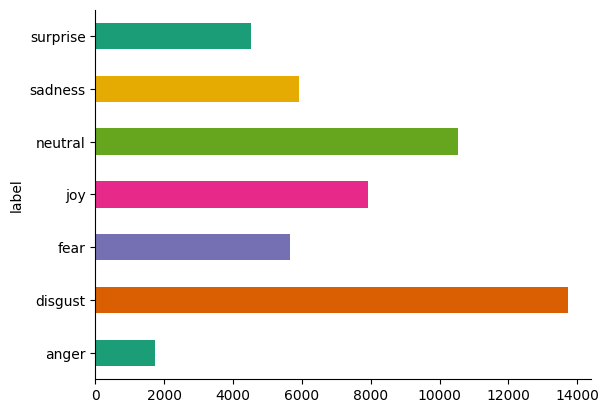

In [ ]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Export results

In [ ]:
# save results to csv
FILENAME = "EMOTIONS.csv"  # name your output file
df.to_csv(FILENAME)